# Ricardo Neves Junior


- email: ricardobnjunior@gmail.com
- github: https://github.com/ricardobnjunior/fpso-equipment-failure-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Tuple, Dict, List, Optional
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import io, textwrap
from contextlib import redirect_stdout
from matplotlib.backends.backend_pdf import PdfPages


# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

In [2]:

class FPSOEquipmentAnalysis:
    """
    Main class for analyzing failures in FPSO equipment.
    Implements all 5 tasks requested in the test.
    """
    
    def __init__(self, file_path: str):
        """
        Initializes the analysis by loading the data.
        
        Args:
            file_path (str): Path to the Excel file with the data
        """
        self.file_path = file_path
        self.df = None
        self.models = {}
        self.feature_importance = {}
        self.results = {}
        
    def load_data(self) -> None:
        """
        Loads and prepares data from the Excel file.
        Automatically tries different formats and sheets.
        """
        try:
            # Try loading in different ways
            try:
                self.df = pd.read_excel(self.file_path)
            except:
                # If it fails, try specifying the engine
                self.df = pd.read_excel(self.file_path, engine='openpyxl')
            
            print(f" Data successfully loaded!")
            print(f"   - Shape: {self.df.shape}")
            print(f"   - Columns: {list(self.df.columns)}")
            
            # Standardize column names (strip spaces, lowercase)
            self.df.columns = self.df.columns.str.strip().str.lower()
            
            # Check for expected columns
            expected_cols = ['cycle', 'preset_1', 'preset_2', 'temperature', 
                           'vibrations_x', 'vibrations_y', 'vibrations_z', 'frequency', 'fail']
            
            # Adjust column names if necessary
            col_mapping = {}
            for col in self.df.columns:
                if 'preset' in col and '1' in col:
                    col_mapping[col] = 'preset_1'
                elif 'preset' in col and '2' in col:
                    col_mapping[col] = 'preset_2'
                elif 'temp' in col:
                    col_mapping[col] = 'temperature'
                elif 'vibr' in col and 'x' in col:
                    col_mapping[col] = 'vibrations_x'
                elif 'vibr' in col and 'y' in col:
                    col_mapping[col] = 'vibrations_y'
                elif 'vibr' in col and 'z' in col:
                    col_mapping[col] = 'vibrations_z'
                elif 'freq' in col:
                    col_mapping[col] = 'frequency'
                elif 'fail' in col:
                    col_mapping[col] = 'fail'
                elif 'cycle' in col:
                    col_mapping[col] = 'cycle'
            
            if col_mapping:
                self.df.rename(columns=col_mapping, inplace=True)
                
        except Exception as e:
            print(f" Error loading data: {e}")
            print("   Check if the file exists and is in the correct format.")
            return
    
    def initial_exploration(self) -> None:
        """
        Performs initial exploratory data analysis.
        """
        print("\n" + "="*80)
        print("INITIAL EXPLORATORY ANALYSIS")
        print("="*80)
        
        # Basic information
        print("\n BASIC INFO:")
        print(f"   - Number of records: {len(self.df):,}")
        print(f"   - Number of columns: {len(self.df.columns)}")
        print(f"   - Period: Cycle {self.df['cycle'].min()} to {self.df['cycle'].max()}")
        
        # Data types
        print(f"\n DATA TYPES:")
        for col in self.df.columns:
            print(f"   - {col}: {self.df[col].dtype}")
        
        # Missing values
        print(f"\n MISSING VALUES:")
        missing = self.df.isnull().sum()
        for col in missing[missing > 0].index:
            pct = (missing[col] / len(self.df)) * 100
            print(f"   - {col}: {missing[col]} ({pct:.1f}%)")
        
        # Descriptive statistics
        print(f"\n DESCRIPTIVE STATISTICS:")
        print(self.df.describe())
        
        # Initial visualizations
        self._plot_initial_exploration()
    
    def _plot_initial_exploration(self) -> None:
        """
        Creates visualizations for the initial exploratory analysis.
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Initial Exploratory Analysis', fontsize=16, y=0.98)
        
        # 1. Failures over time
        axes[0,0].plot(self.df['cycle'], self.df['fail'], alpha=0.7)
        axes[0,0].set_title('Failures Over Time')
        axes[0,0].set_xlabel('Cycle')
        axes[0,0].set_ylabel('Fail Status')
        
        # 2. Temperature distribution
        axes[0,1].hist(self.df['temperature'], bins=50, alpha=0.7, color='red')
        axes[0,1].set_title('Temperature Distribution')
        axes[0,1].set_xlabel('Temperature')
        axes[0,1].set_ylabel('Frequency')
        
        # 3. Frequency distribution
        axes[0,2].hist(self.df['frequency'], bins=50, alpha=0.7, color='green')
        axes[0,2].set_title('Frequency Distribution')
        axes[0,2].set_xlabel('Frequency')
        axes[0,2].set_ylabel('Frequency')
        
        # 4. Vibration box plots
        vibration_cols = ['vibrations_x', 'vibrations_y', 'vibrations_z']
        vibration_data = [self.df[col] for col in vibration_cols if col in self.df.columns]
        axes[1,0].boxplot(vibration_data, labels=[col.replace('vibrations_', '') for col in vibration_cols])
        axes[1,0].set_title('Vibration Distribution')
        axes[1,0].set_ylabel('Value')
        
        # 5. Correlation matrix
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        corr_matrix = self.df[numeric_cols].corr()
        im = axes[1,1].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
        axes[1,1].set_xticks(range(len(numeric_cols)))
        axes[1,1].set_yticks(range(len(numeric_cols)))
        axes[1,1].set_xticklabels(numeric_cols, rotation=45)
        axes[1,1].set_yticklabels(numeric_cols)
        axes[1,1].set_title('Correlation Matrix')
        
        # 6. Preset distribution
        preset_counts = self.df.groupby(['preset_1', 'preset_2']).size().reset_index(name='count')
        axes[1,2].scatter(preset_counts['preset_1'], preset_counts['preset_2'], 
                         s=preset_counts['count']/10, alpha=0.6)
        axes[1,2].set_title('Preset Distribution')
        axes[1,2].set_xlabel('Preset 1')
        axes[1,2].set_ylabel('Preset 2')
        
        plt.tight_layout()
        plt.show()


    def task_1_count_failures(self) -> Dict:
        """
        TASK 1: Counts how many times the equipment failed.
        Distinguishes between failure states and failure events.
        
        Returns:
            Dict: Failure analysis results
        """
        print("\n" + "="*80)
        print("TASK 1: FAILURE ANALYSIS")
        print("="*80)
        
        # Basic failure analysis
        total_records = len(self.df)
        failure_records = self.df['fail'].sum()
        failure_rate = (failure_records / total_records) * 100
        
        print(f"\n BASIC STATS:")
        print(f"   - Total records: {total_records:,}")
        print(f"   - Records with failure: {failure_records:,}")
        print(f"   - Failure rate: {failure_rate:.2f}%")
        
        # Count of failure events (0->1 transitions)
        self.df['fail_shift'] = self.df['fail'].shift(1, fill_value=0)
        failure_events = ((self.df['fail'] == 1) & (self.df['fail_shift'] == 0)).sum()
        
        print(f"\n FAILURE EVENTS:")
        print(f"   - Number of failure events: {failure_events}")
        
        # Failure duration analysis
        failure_durations = []
        current_duration = 0
        
        for fail_status in self.df['fail']:
            if fail_status == 1:
                current_duration += 1
            else:
                if current_duration > 0:
                    failure_durations.append(current_duration)
                    current_duration = 0
        
        # Add last duration if sequence ends in failure
        if current_duration > 0:
            failure_durations.append(current_duration)
        
        if failure_durations:
            avg_duration = np.mean(failure_durations)
            max_duration = max(failure_durations)
            min_duration = min(failure_durations)
            
            print(f"\n  FAILURE DURATIONS:")
            print(f"   - Average duration: {avg_duration:.1f} cycles")
            print(f"   - Maximum duration: {max_duration} cycles")
            print(f"   - Minimum duration: {min_duration} cycles")
        
        # Visualization
        self._plot_failure_analysis()
        
        # Save results
        results = {
            'total_records': total_records,
            'failure_records': failure_records,
            'failure_rate': failure_rate,
            'failure_events': failure_events,
            'failure_durations': failure_durations
        }
        
        self.results['task_1'] = results
        return results
    
    def _plot_failure_analysis(self) -> None:
        """
        Creates visualizations for the failure analysis.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('TASK 1: Failure Analysis', fontsize=16)
        
        # 1. Failure timeline
        axes[0,0].plot(self.df['cycle'], self.df['fail'], color='red', alpha=0.7)
        axes[0,0].fill_between(self.df['cycle'], self.df['fail'], alpha=0.3, color='red')
        axes[0,0].set_title('Failure Timeline')
        axes[0,0].set_xlabel('Cycle')
        axes[0,0].set_ylabel('Fail Status')
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. State distribution
        fail_counts = self.df['fail'].value_counts()
        axes[0,1].pie(fail_counts.values, labels=['Normal', 'Failure'], autopct='%1.1f%%',
                     colors=['lightgreen', 'red'])
        axes[0,1].set_title('State Distribution')
        
        # 3. Failure duration histogram
        if hasattr(self, 'results') and 'task_1' in self.results:
            durations = self.results['task_1']['failure_durations']
            if durations:
                axes[1,0].hist(durations, bins=20, alpha=0.7, color='orange')
                axes[1,0].set_title('Failure Duration Distribution')
                axes[1,0].set_xlabel('Duration (cycles)')
                axes[1,0].set_ylabel('Frequency')
                axes[1,0].grid(True, alpha=0.3)
        
        # 4. Temporal analysis (failures by period)
        self.df['period'] = pd.cut(self.df['cycle'], bins=10)
        period_failures = self.df.groupby('period')['fail'].mean()
        axes[1,1].bar(range(len(period_failures)), period_failures.values, alpha=0.7, color='purple')
        axes[1,1].set_title('Failure Rate by Period')
        axes[1,1].set_xlabel('Period')
        axes[1,1].set_ylabel('Failure Rate')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()


    
    def task_2_analyze_by_presets(self) -> Dict:
        """
        TASK 2: Categorizes failures by preset configurations.
        
        Returns:
            Dict: Detailed analysis by presets
        """
        print("\n" + "="*80)
        print("TASK 2: ANALYSIS BY CONFIGURATIONS (PRESETS)")
        print("="*80)
        
        # Descriptive analysis of presets
        print(f"\n PRESET ANALYSIS:")
        print(f"   - Preset 1 - Unique values: {self.df['preset_1'].nunique()}")
        print(f"   - Preset 1 - Range: {self.df['preset_1'].min()} to {self.df['preset_1'].max()}")
        print(f"   - Preset 2 - Unique values: {self.df['preset_2'].nunique()}")
        print(f"   - Preset 2 - Range: {self.df['preset_2'].min()} to {self.df['preset_2'].max()}")
        
        # Failure analysis by preset combination
        preset_analysis = self.df.groupby(['preset_1', 'preset_2']).agg({
            'fail': ['count', 'sum', 'mean'],
            'cycle': 'count'
        }).round(4)
        
        preset_analysis.columns = ['total_records', 'total_failures', 'failure_rate', 'cycles']
        preset_analysis = preset_analysis.reset_index()
        preset_analysis = preset_analysis.sort_values('failure_rate', ascending=False)
        
        print(f"\n TOP 10 COMBINATIONS WITH HIGHEST FAILURE RATE:")
        print(preset_analysis.head(10).to_string(index=False))
        
        # Individual preset analysis
        print(f"\n INDIVIDUAL ANALYSIS:")
        
        # Preset 1
        preset1_analysis = self.df.groupby('preset_1').agg({
            'fail': ['count', 'sum', 'mean']
        }).round(4)
        preset1_analysis.columns = ['records', 'failures', 'failure_rate']
        print(f"\n   PRESET 1 - Top 5 with highest failure rate:")
        print(preset1_analysis.sort_values('failure_rate', ascending=False).head().to_string())
        
        # Preset 2
        preset2_analysis = self.df.groupby('preset_2').agg({
            'fail': ['count', 'sum', 'mean']
        }).round(4)
        preset2_analysis.columns = ['records', 'failures', 'failure_rate']
        print(f"\n   PRESET 2 - Top 5 with highest failure rate:")
        print(preset2_analysis.sort_values('failure_rate', ascending=False).head().to_string())
        
        # Pattern insights
        self._analyze_preset_patterns()
        
        # Visualizations
        self._plot_preset_analysis(preset_analysis)
        
        # Save results
        results = {
            'preset_combinations': preset_analysis,
            'preset1_analysis': preset1_analysis,
            'preset2_analysis': preset2_analysis
        }
        
        self.results['task_2'] = results
        return results
    
    def _analyze_preset_patterns(self) -> None:
        """
        Analyzes patterns in presets during operation.
        """
        print(f"\n INSIGHTS ON PRESET PATTERNS:")
        
        # Correlation between presets and failures
        corr_preset1 = self.df['preset_1'].corr(self.df['fail'])
        corr_preset2 = self.df['preset_2'].corr(self.df['fail'])
        
        print(f"   - Correlation Preset 1 vs Failures: {corr_preset1:.4f}")
        print(f"   - Correlation Preset 2 vs Failures: {corr_preset2:.4f}")
        
        # Preset stability over time
        preset1_stability = self.df['preset_1'].std()
        preset2_stability = self.df['preset_2'].std()
        
        print(f"   - Variability Preset 1: {preset1_stability:.4f}")
        print(f"   - Variability Preset 2: {preset2_stability:.4f}")
        
        # Preset changes analysis
        preset1_changes = (self.df['preset_1'].diff() != 0).sum()
        preset2_changes = (self.df['preset_2'].diff() != 0).sum()
        
        print(f"   - Changes in Preset 1: {preset1_changes}")
        print(f"   - Changes in Preset 2: {preset2_changes}")
        
    def _plot_preset_analysis(self, preset_analysis: pd.DataFrame) -> None:
        """
        Creates visualizations for the preset analysis.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('TASK 2: Analysis by Configurations (Presets)', fontsize=16)
        
        # 1. Heatmap of failures by preset combination
        pivot_table = self.df.pivot_table(values='fail', index='preset_1', columns='preset_2', aggfunc='mean')
        sns.heatmap(pivot_table, annot=True, cmap='Reds', ax=axes[0,0], fmt='.3f')
        axes[0,0].set_title('Failure Rate by Preset Combination')
        
        # 2. Box plot of preset 1 by failure status
        sns.boxplot(data=self.df, x='fail', y='preset_1', ax=axes[0,1])
        axes[0,1].set_title('Preset 1 vs Failure Status')
        axes[0,1].set_xlabel('Fail Status')
        
        # 3. Box plot of preset 2 by failure status
        sns.boxplot(data=self.df, x='fail', y='preset_2', ax=axes[1,0])
        axes[1,0].set_title('Preset 2 vs Failure Status')
        axes[1,0].set_xlabel('Fail Status')
        
        # 4. Scatter plot of presets colored by failures
        scatter = axes[1,1].scatter(self.df['preset_1'], self.df['preset_2'], 
                                   c=self.df['fail'], cmap='RdYlBu_r', alpha=0.6)
        axes[1,1].set_title('Preset Distribution (color = failure)')
        axes[1,1].set_xlabel('Preset 1')
        axes[1,1].set_ylabel('Preset 2')
        plt.colorbar(scatter, ax=axes[1,1])
        
        plt.tight_layout()
        plt.show()


    
    def task_3_root_cause_analysis(self) -> Dict:
        """
        TASK 3: Categorizes failures by root cause based on physical parameters.
        
        Returns:
            Dict: Root cause analysis of failures
        """
        print("\n" + "="*80)
        print("TASK 3: ROOT CAUSE ANALYSIS")
        print("="*80)
        
        # Split normal and failure data
        normal_data = self.df[self.df['fail'] == 0]
        failure_data = self.df[self.df['fail'] == 1]
        
        print(f"\n STATISTICAL COMPARISON:")
        print(f"   - Normal records: {len(normal_data):,}")
        print(f"   - Failure records: {len(failure_data):,}")
        
        # Physical variables analysis
        physical_vars = ['temperature', 'vibrations_x', 'vibrations_y', 'vibrations_z', 'frequency']
        
        comparison_results = {}
        
        for var in physical_vars:
            if var in self.df.columns:
                normal_mean = normal_data[var].mean()
                failure_mean = failure_data[var].mean()
                normal_std = normal_data[var].std()
                failure_std = failure_data[var].std()
                
                # t-test for significant difference
                t_stat, p_value = stats.ttest_ind(normal_data[var], failure_data[var])
                
                comparison_results[var] = {
                    'normal_mean': normal_mean,
                    'failure_mean': failure_mean,
                    'normal_std': normal_std,
                    'failure_std': failure_std,
                    'difference': failure_mean - normal_mean,
                    'percent_change': ((failure_mean - normal_mean) / normal_mean) * 100,
                    't_statistic': t_stat,
                    'p_value': p_value
                }
                
                print(f"\n   {var.upper()}:")
                print(f"      - Normal: {normal_mean:.2f} ± {normal_std:.2f}")
                print(f"      - Failure: {failure_mean:.2f} ± {failure_std:.2f}")
                print(f"      - Difference: {failure_mean - normal_mean:.2f} ({((failure_mean - normal_mean) / normal_mean) * 100:.1f}%)")
                print(f"      - Significance (p-value): {p_value:.6f}")
        
        # Identify critical thresholds
        self._identify_critical_thresholds(normal_data, failure_data, physical_vars)
        
        # Pre-failure temporal analysis
        self._analyze_pre_failure_patterns()
        
        # Failure type classification
        failure_types = self._classify_failure_types(failure_data, comparison_results)
        
        # Visualizations
        self._plot_root_cause_analysis(normal_data, failure_data, physical_vars)
        
        # Save results
        results = {
            'comparison_results': comparison_results,
            'failure_types': failure_types
        }
        
        self.results['task_3'] = results
        return results
    
    def _identify_critical_thresholds(self, normal_data: pd.DataFrame, 
                                    failure_data: pd.DataFrame, 
                                    physical_vars: List[str]) -> None:
        """
        Identifies critical thresholds for each variable.
        """
        print(f"\n CRITICAL THRESHOLDS:")
        
        for var in physical_vars:
            if var in self.df.columns:
                # Percentiles for normal data
                normal_95th = normal_data[var].quantile(0.95)
                normal_5th = normal_data[var].quantile(0.05)
                
                # Percentiles for failure data
                failure_median = failure_data[var].median()
                
                print(f"\n   {var.UPPER() if hasattr(str, 'UPPER') else var.upper()}:")
                print(f"      - Normal (5th-95th percentile): {normal_5th:.2f} - {normal_95th:.2f}")
                print(f"      - Failure (median): {failure_median:.2f}")
                
                if failure_median > normal_95th:
                    print(f"      - UPPER THRESHOLD: Failures occur when {var} > {normal_95th:.2f}")
                elif failure_median < normal_5th:
                    print(f"      - LOWER THRESHOLD: Failures occur when {var} < {normal_5th:.2f}")
    
    def _analyze_pre_failure_patterns(self) -> None:
        """
        Analyzes patterns before failures.
        """
        print(f"\nPRE-FAILURE ANALYSIS:")
        
        # Identify failure starts
        fail_starts = self.df[(self.df['fail'] == 1) & (self.df['fail'].shift(1) == 0)].index
        
        if len(fail_starts) > 0:
            # Analyze 5 cycles before each failure
            lookback_cycles = 5
            pre_failure_data = []
            
            for start_idx in fail_starts:
                start_cycle = max(0, start_idx - lookback_cycles)
                pre_failure_data.append(self.df.iloc[start_cycle:start_idx])
            
            if pre_failure_data:
                pre_failure_df = pd.concat(pre_failure_data)
                
                print(f"   - Analyzing {lookback_cycles} cycles before {len(fail_starts)} failure events")
                
                for var in ['temperature', 'vibrations_x', 'vibrations_y', 'vibrations_z', 'frequency']:
                    if var in self.df.columns:
                        trend = pre_failure_df[var].diff().mean()
                        print(f"   - {var}: Pre-failure trend = {trend:.4f}")
    
    def _classify_failure_types(self, failure_data: pd.DataFrame, 
                              comparison_results: Dict) -> Dict:
        """
        Classifies failure types based on variable patterns.
        """
        print(f"\nFAILURE TYPE CLASSIFICATION:")
        
        failure_types = {}
        
        # Temperature-related failures
        temp_failures = failure_data[
            failure_data['temperature'] > failure_data['temperature'].quantile(0.8)
        ]
        failure_types['thermal'] = len(temp_failures)
        
        # Vibration-related failures
        vibration_cols = ['vibrations_x', 'vibrations_y', 'vibrations_z']
        high_vibration_failures = failure_data[
            (failure_data[vibration_cols] > failure_data[vibration_cols].quantile(0.8)).any(axis=1)
        ]
        failure_types['mechanical'] = len(high_vibration_failures)
        
        # Frequency-related failures
        freq_failures = failure_data[
            (failure_data['frequency'] > failure_data['frequency'].quantile(0.9)) |
            (failure_data['frequency'] < failure_data['frequency'].quantile(0.1))
        ]
        failure_types['operational'] = len(freq_failures)
        
        print(f"   - Thermal Failures: {failure_types['thermal']} ({(failure_types['thermal']/len(failure_data)*100):.1f}%)")
        print(f"   - Mechanical Failures: {failure_types['mechanical']} ({(failure_types['mechanical']/len(failure_data)*100):.1f}%)")
        print(f"   - Operational Failures: {failure_types['operational']} ({(failure_types['operational']/len(failure_data)*100):.1f}%)")
        
        return failure_types
    
    def _plot_root_cause_analysis(self, normal_data: pd.DataFrame, 
                                failure_data: pd.DataFrame, 
                                physical_vars: List[str]) -> None:
        """
        Creates visualizations for the root cause analysis.
        """
        n_vars = len(physical_vars)
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('TASK 3: Root Cause Analysis', fontsize=16)
        
        axes = axes.flatten()
        
        for i, var in enumerate(physical_vars):
            if var in self.df.columns and i < len(axes):
                # Comparative histograms
                axes[i].hist(normal_data[var], bins=30, alpha=0.7, label='Normal', 
                           color='blue', density=True)
                axes[i].hist(failure_data[var], bins=30, alpha=0.7, label='Failure', 
                           color='red', density=True)
                axes[i].set_title(f'{var.capitalize()}')
                axes[i].set_xlabel('Value')
                axes[i].set_ylabel('Density')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)
        
        # Remove empty axes
        for i in range(n_vars, len(axes)):
            axes[i].remove()
        
        plt.tight_layout()
        plt.show()
        
        # Second figure: Comparative box plots
        fig2, axes2 = plt.subplots(1, len(physical_vars), figsize=(20, 5))
        fig2.suptitle('Variable Comparison: Normal vs Failure', fontsize=16)
        
        for i, var in enumerate(physical_vars):
            if var in self.df.columns:
                data_to_plot = [normal_data[var], failure_data[var]]
                axes2[i].boxplot(data_to_plot, labels=['Normal', 'Failure'])
                axes2[i].set_title(f'{var.capitalize()}')
                axes2[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    
    def task_4_build_models(self) -> Dict:
        """
        TASK 4: Builds and evaluates models for failure prediction.
        
        Returns:
            Dict: Model results and performance metrics
        """
        print("\n" + "="*80)
        print("TASK 4: MODEL DEVELOPMENT")
        print("="*80)
        
        # Data preparation
        X, y = self._prepare_features_and_target()
        
        # Temporal split
        X_train, X_test, y_train, y_test = self._temporal_split(X, y)
        
        print(f"\n DATA SPLIT:")
        print(f"   - Train: {len(X_train):,} records ({y_train.sum()} failures)")
        print(f"   - Test: {len(X_test):,} records ({y_test.sum()} failures)")
        
        # Models to test
        models_config = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, 
                                                   class_weight='balanced'),
        }
        
        # Train and evaluate models
        model_results = {}
        
        for model_name, model in models_config.items():
            print(f"\n🔧 Training {model_name}...")
            
            # Scaling for Logistic Regression
            if 'Logistic' in model_name:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Evaluation metrics
            auc_score = roc_auc_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred)
            
            model_results[model_name] = {
                'model': model,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'auc_score': auc_score,
                'f1_score': f1,
                'classification_report': classification_report(y_test, y_pred)
            }
            
            print(f"   AUC Score: {auc_score:.4f}")
            print(f"   F1 Score: {f1:.4f}")
        
        # Temporal cross-validation
        self._perform_temporal_cross_validation(X, y, models_config)
        
        # Best model selection
        best_model_name = max(model_results.keys(), 
                            key=lambda x: model_results[x]['auc_score'])
        
        print(f"\nBEST MODEL: {best_model_name}")
        print(f"   - AUC Score: {model_results[best_model_name]['auc_score']:.4f}")
        print(f"   - F1 Score: {model_results[best_model_name]['f1_score']:.4f}")
        
        # Save best model
        self.models['best_model'] = model_results[best_model_name]['model']
        self.models['best_model_name'] = best_model_name
        
        # Visualizations
        self._plot_model_evaluation(model_results, y_test)
        
        # Save results
        self.results['task_4'] = {
            'model_results': model_results,
            'best_model_name': best_model_name,
            'feature_names': list(X.columns)
        }
        
        return model_results
    
    def _prepare_features_and_target(self) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Prepares features and target for modeling.
        """
        print(f"\n FEATURE ENGINEERING:")
        
        # Base features
        feature_cols = ['preset_1', 'preset_2', 'temperature', 'vibrations_x', 
                       'vibrations_y', 'vibrations_z', 'frequency']
        
        # Remove columns that don't exist
        feature_cols = [col for col in feature_cols if col in self.df.columns]
        
        X = self.df[feature_cols].copy()
        
        # Lag features (previous values)
        lag_periods = [1, 2, 3]
        for col in ['temperature', 'frequency']:
            if col in X.columns:
                for lag in lag_periods:
                    X[f'{col}_lag_{lag}'] = self.df[col].shift(lag)
        
        # Rolling mean features
        window_sizes = [3, 5]
        for col in ['temperature', 'vibrations_x', 'vibrations_y', 'vibrations_z']:
            if col in X.columns:
                for window in window_sizes:
                    X[f'{col}_rolling_mean_{window}'] = self.df[col].rolling(window=window).mean()
        
        # Variability features
        for col in ['vibrations_x', 'vibrations_y', 'vibrations_z']:
            if col in X.columns:
                X[f'{col}_rolling_std_3'] = self.df[col].rolling(window=3).std()
        
        # Drop rows with NaN (due to lags and rolling)
        X = X.dropna()
        y = self.df.loc[X.index, 'fail']
        
        print(f"   - Features created: {len(X.columns)}")
        print(f"   - Records after cleaning: {len(X):,}")
        
        return X, y
    
    def _temporal_split(self, X: pd.DataFrame, y: pd.Series, test_size: float = 0.2) -> Tuple:
        """
        Temporal split of the data (last 20% for testing).
        """
        split_point = int(len(X) * (1 - test_size))
        
        X_train = X.iloc[:split_point]
        X_test = X.iloc[split_point:]
        y_train = y.iloc[:split_point]
        y_test = y.iloc[split_point:]
        
        return X_train, X_test, y_train, y_test
    
    def _perform_temporal_cross_validation(self, X: pd.DataFrame, y: pd.Series, 
                                         models_config: Dict) -> None:
        """
        Performs temporal cross-validation.
        """
        print(f"\n TEMPORAL CROSS-VALIDATION:")
        
        tscv = TimeSeriesSplit(n_splits=3)
        
        for model_name, model in models_config.items():
            cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc')
            print(f"   - {model_name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    def _plot_model_evaluation(self, model_results: Dict, y_test: pd.Series) -> None:
        """
        Creates visualizations for model evaluation.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('TASK 4: Model Evaluation', fontsize=16)
        
        # 1. ROC Curves
        for model_name, results in model_results.items():
            fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
            axes[0,0].plot(fpr, tpr, label=f"{model_name} (AUC: {results['auc_score']:.3f})")
        
        axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0,0].set_xlabel('False Positive Rate')
        axes[0,0].set_ylabel('True Positive Rate')
        axes[0,0].set_title('ROC Curves')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Precision-Recall Curves
        for model_name, results in model_results.items():
            precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
            axes[0,1].plot(recall, precision, label=f"{model_name} (F1: {results['f1_score']:.3f})")
        
        axes[0,1].set_xlabel('Recall')
        axes[0,1].set_ylabel('Precision')
        axes[0,1].set_title('Precision-Recall Curves')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Confusion Matrix (best model)
        best_model_name = max(model_results.keys(), 
                            key=lambda x: model_results[x]['auc_score'])
        cm = confusion_matrix(y_test, model_results[best_model_name]['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
        axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')
        
        # 4. Feature Importance (if Random Forest is best)
        if 'Random Forest' in best_model_name:
            model = model_results[best_model_name]['model']
            importances = model.feature_importances_
            feature_names = self.results['task_4']['feature_names']
            
            # Top 10 most important features
            indices = np.argsort(importances)[::-1][:10]
            axes[1,1].bar(range(10), importances[indices])
            axes[1,1].set_xticks(range(10))
            axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[1,1].set_title('Top 10 Most Important Features')
            axes[1,1].set_ylabel('Importance')
        
        plt.tight_layout()
        plt.show()


    def task_5_variable_importance(self) -> Dict:
        """
        TASK 5: Analyzes variable importance in the model.
        
        Returns:
            Dict: Variable importance analysis
        """
        print("\n" + "="*80)
        print("TASK 5: VARIABLE IMPORTANCE ANALYSIS")
        print("="*80)
        
        if 'best_model' not in self.models:
            print("Error: Run Task 4 first to train the models.")
            return {}
        
        model = self.models['best_model']
        model_name = self.models['best_model_name']
        feature_names = self.results['task_4']['feature_names']
        
        print(f"\nAnalyzing importance for model: {model_name}")
        
        importance_results = {}
        
        # Method 1: Native feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Create DataFrame for easier analysis
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            print(f"\n TOP 10 MOST IMPORTANT VARIABLES:")
            for i, row in importance_df.head(10).iterrows():
                print(f"   {row['feature']}: {row['importance']:.4f}")
            
            importance_results['feature_importance'] = importance_df
        
        # Method 2: Correlation with target
        X, y = self._prepare_features_and_target()
        correlations = {}
        
        print(f"\n CORRELATION WITH FAILURES:")
        for feature in feature_names:
            if feature in X.columns:
                corr = X[feature].corr(y)
                correlations[feature] = abs(corr)
                
        # Top 10 correlations
        sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:10]
        for feature, corr in sorted_correlations:
            print(f"   {feature}: {corr:.4f}")
        
        importance_results['correlations'] = correlations
        
        # Method 3: Statistical analysis (difference in means)
        normal_data = self.df[self.df['fail'] == 0]
        failure_data = self.df[self.df['fail'] == 1]
        
        statistical_importance = {}
        
        print(f"\nSTATISTICAL SIGNIFICANCE (p-values):")
        for feature in ['preset_1', 'preset_2', 'temperature', 'vibrations_x', 
                       'vibrations_y', 'vibrations_z', 'frequency']:
            if feature in self.df.columns:
                try:
                    t_stat, p_value = stats.ttest_ind(normal_data[feature], failure_data[feature])
                    statistical_importance[feature] = p_value
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    print(f"   {feature}: p={p_value:.6f} {significance}")
                except:
                    print(f"   {feature}: Error computing statistic")
        
        importance_results['statistical_significance'] = statistical_importance
        
        # Business impact analysis
        self._analyze_business_impact(importance_results)
        
        # Visualizations
        self._plot_variable_importance(importance_results)
        
        # Save results
        self.results['task_5'] = importance_results
        return importance_results
    
    def _analyze_business_impact(self, importance_results: Dict) -> None:
        """
        Analyzes variable impact from a business perspective.
        """
        print(f"\n BUSINESS IMPACT:")
        
        # Controllable vs non-controllable variables
        controllable_vars = ['preset_1', 'preset_2']
        monitoring_vars = ['temperature', 'vibrations_x', 'vibrations_y', 'vibrations_z', 'frequency']
        
        print(f"\n  CONTROLLABLE VARIABLES (can be adjusted):")
        if 'correlations' in importance_results:
            for var in controllable_vars:
                if var in importance_results['correlations']:
                    corr = importance_results['correlations'][var]
                    print(f"      - {var}: Correlation = {corr:.4f}")
                    if corr > 0.1:
                        print(f"       Recommendation: Consider adjusting this setting")
        
        print(f"\n   MONITORING VARIABLES (failure indicators):")
        if 'correlations' in importance_results:
            for var in monitoring_vars:
                if var in importance_results['correlations']:
                    corr = importance_results['correlations'][var]
                    print(f"      - {var}: Correlation = {corr:.4f}")
                    if corr > 0.2:
                        print(f"        Recommendation: Implement an alarm for this variable")
    
    def _plot_variable_importance(self, importance_results: Dict) -> None:
        """
        Creates visualizations for variable importance.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('TASK 5: Variable Importance', fontsize=16)
        
        # 1. Feature importance (if available)
        if 'feature_importance' in importance_results:
            df = importance_results['feature_importance'].head(10)
            axes[0,0].barh(df['feature'], df['importance'])
            axes[0,0].set_title('Feature Importance (Model)')
            axes[0,0].set_xlabel('Importance')
            axes[0,0].invert_yaxis()
        
        # 2. Correlations
        if 'correlations' in importance_results:
            correlations = importance_results['correlations']
            features = list(correlations.keys())[:10]
            values = [correlations[f] for f in features]
            
            axes[0,1].barh(features, values, color='orange')
            axes[0,1].set_title('Absolute Correlation with Failures')
            axes[0,1].set_xlabel('Absolute Correlation')
            axes[0,1].invert_yaxis()
        
        # 3. Statistical significance
        if 'statistical_significance' in importance_results:
            stats_data = importance_results['statistical_significance']
            features = list(stats_data.keys())
            p_values = [-np.log10(stats_data[f]) for f in features]  # -log10 for better visualization
            
            axes[1,0].bar(features, p_values, color='green')
            axes[1,0].set_title('Statistical Significance (-log10 p-value)')
            axes[1,0].set_ylabel('-log10(p-value)')
            axes[1,0].tick_params(axis='x', rotation=45)
            axes[1,0].axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
            axes[1,0].legend()
        
        # 4. Feature-to-feature correlation heatmap
        X, y = self._prepare_features_and_target()
        feature_corr = X.corr()
        
        # Select only a few features for visualization
        important_features = list(importance_results.get('correlations', {}).keys())[:8]
        if important_features:
            subset_corr = feature_corr.loc[important_features, important_features]
            sns.heatmap(subset_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
            axes[1,1].set_title('Correlation Among Important Features')
        
        plt.tight_layout()
        plt.show()

    def run_complete_analysis(self) -> None:
        """
        Runs all 5 tasks in sequence.
        """
        print("STARTING COMPLETE FAILURE ANALYSIS FOR FPSO EQUIPMENT")
        print("="*80)
        
        try:
            # Load and initial exploration
            self.load_data()
            if self.df is None:
                return
            
            self.initial_exploration()
            
            # Execute the 5 tasks
            self.task_1_count_failures()
            self.task_2_analyze_by_presets()
            self.task_3_root_cause_analysis()
            self.task_4_build_models()
            self.task_5_variable_importance()
            
            # Final report
            self.generate_final_report()
            
            print("\nCOMPLETE ANALYSIS FINISHED!")
            print("="*80)
            
        except Exception as e:
            print(f"Error during execution: {e}")
            import traceback
            traceback.print_exc()
    
    def generate_final_report(self) -> None:
        """
        Generates a final report with insights and recommendations.
        """
        print("\n" + "="*80)
        print("FINAL REPORT AND RECOMMENDATIONS")
        print("="*80)
        
        print(f"\nEXECUTIVE SUMMARY:")
        
        # Task 1 insights
        if 'task_1' in self.results:
            task1 = self.results['task_1']
            print(f"\n   FAILURE ANALYSIS:")
            print(f"      - Overall failure rate: {task1['failure_rate']:.2f}%")
            print(f"      - Number of failure events: {task1['failure_events']}")
            if task1['failure_durations']:
                print(f"      - Average failure duration: {np.mean(task1['failure_durations']):.1f} cycles")
        
        # Task 2 insights
        if 'task_2' in self.results:
            print(f"\n   CRITICAL CONFIGURATIONS:")
            print(f"      - Identified preset combinations with high failure rates")
            print(f"      - Recommendation: Review operational configurations")
        
        # Task 3 insights
        if 'task_3' in self.results:
            print(f"\n   ROOT CAUSES:")
            print(f"      - Identified distinct patterns between normal operation and failure")
            print(f"      - Recommendation: Implement predictive monitoring")
        
        # Task 4 insights
        if 'task_4' in self.results:
            task4 = self.results['task_4']
            best_model = task4['best_model_name']
            best_auc = task4['model_results'][best_model]['auc_score']
            print(f"\n   PREDICTIVE MODEL:")
            print(f"      - Best model: {best_model}")
            print(f"      - Performance (AUC): {best_auc:.3f}")
            print(f"      - Recommendation: Deploy to production for failure prediction")
        
        print(f"\n RECOMMENDATIONS FOR PRODUCTION:")
        print(f"   1. Implement a real-time monitoring system")
        print(f"   2. Configure alarms based on identified thresholds") 
        print(f"   3. Retrain the model periodically with new data")
        print(f"   4. Implement predictive maintenance based on predictions")
        print(f"   5. Monitor data drift and model performance")
        
        print(f"\n NEXT STEPS:")
        print(f"   1. Collect more data to improve the model")
        print(f"   2. Implement more advanced feature engineering")
        print(f"   3. Test deep learning models (LSTM/GRU)")
        print(f"   4. Develop a monitoring dashboard")


In [3]:
analyzer = FPSOEquipmentAnalysis('Test O_G_Equipment_Data.xlsx')
analyzer.load_data()

 Data successfully loaded!
   - Shape: (800, 10)
   - Columns: ['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']



INITIAL EXPLORATORY ANALYSIS

 BASIC INFO:
   - Number of records: 800
   - Number of columns: 10
   - Period: Cycle 1 to 800

 DATA TYPES:
   - cycle: int64
   - preset_1: int64
   - preset_2: int64
   - temperature: float64
   - pressure: float64
   - vibrations_x: float64
   - vibrations_y: float64
   - vibrations_z: float64
   - frequency: float64
   - fail: bool

 MISSING VALUES:

 DESCRIPTIVE STATISTICS:
          cycle    preset_1    preset_2  temperature    pressure  \
count  800.0000  800.000000  800.000000   800.000000  800.000000   
mean   400.5000    1.988750    4.551250    69.263494   78.997945   
std    231.0844    0.805875    2.293239    25.536252   32.501834   
min      1.0000    1.000000    1.000000     2.089354    3.480279   
25%    200.7500    1.000000    3.000000    51.040134   55.508564   
50%    400.5000    2.000000    5.000000    65.906716   75.014848   
75%    600.2500    3.000000    7.000000    80.527220   99.302530   
max    800.0000    3.000000    8.000000  

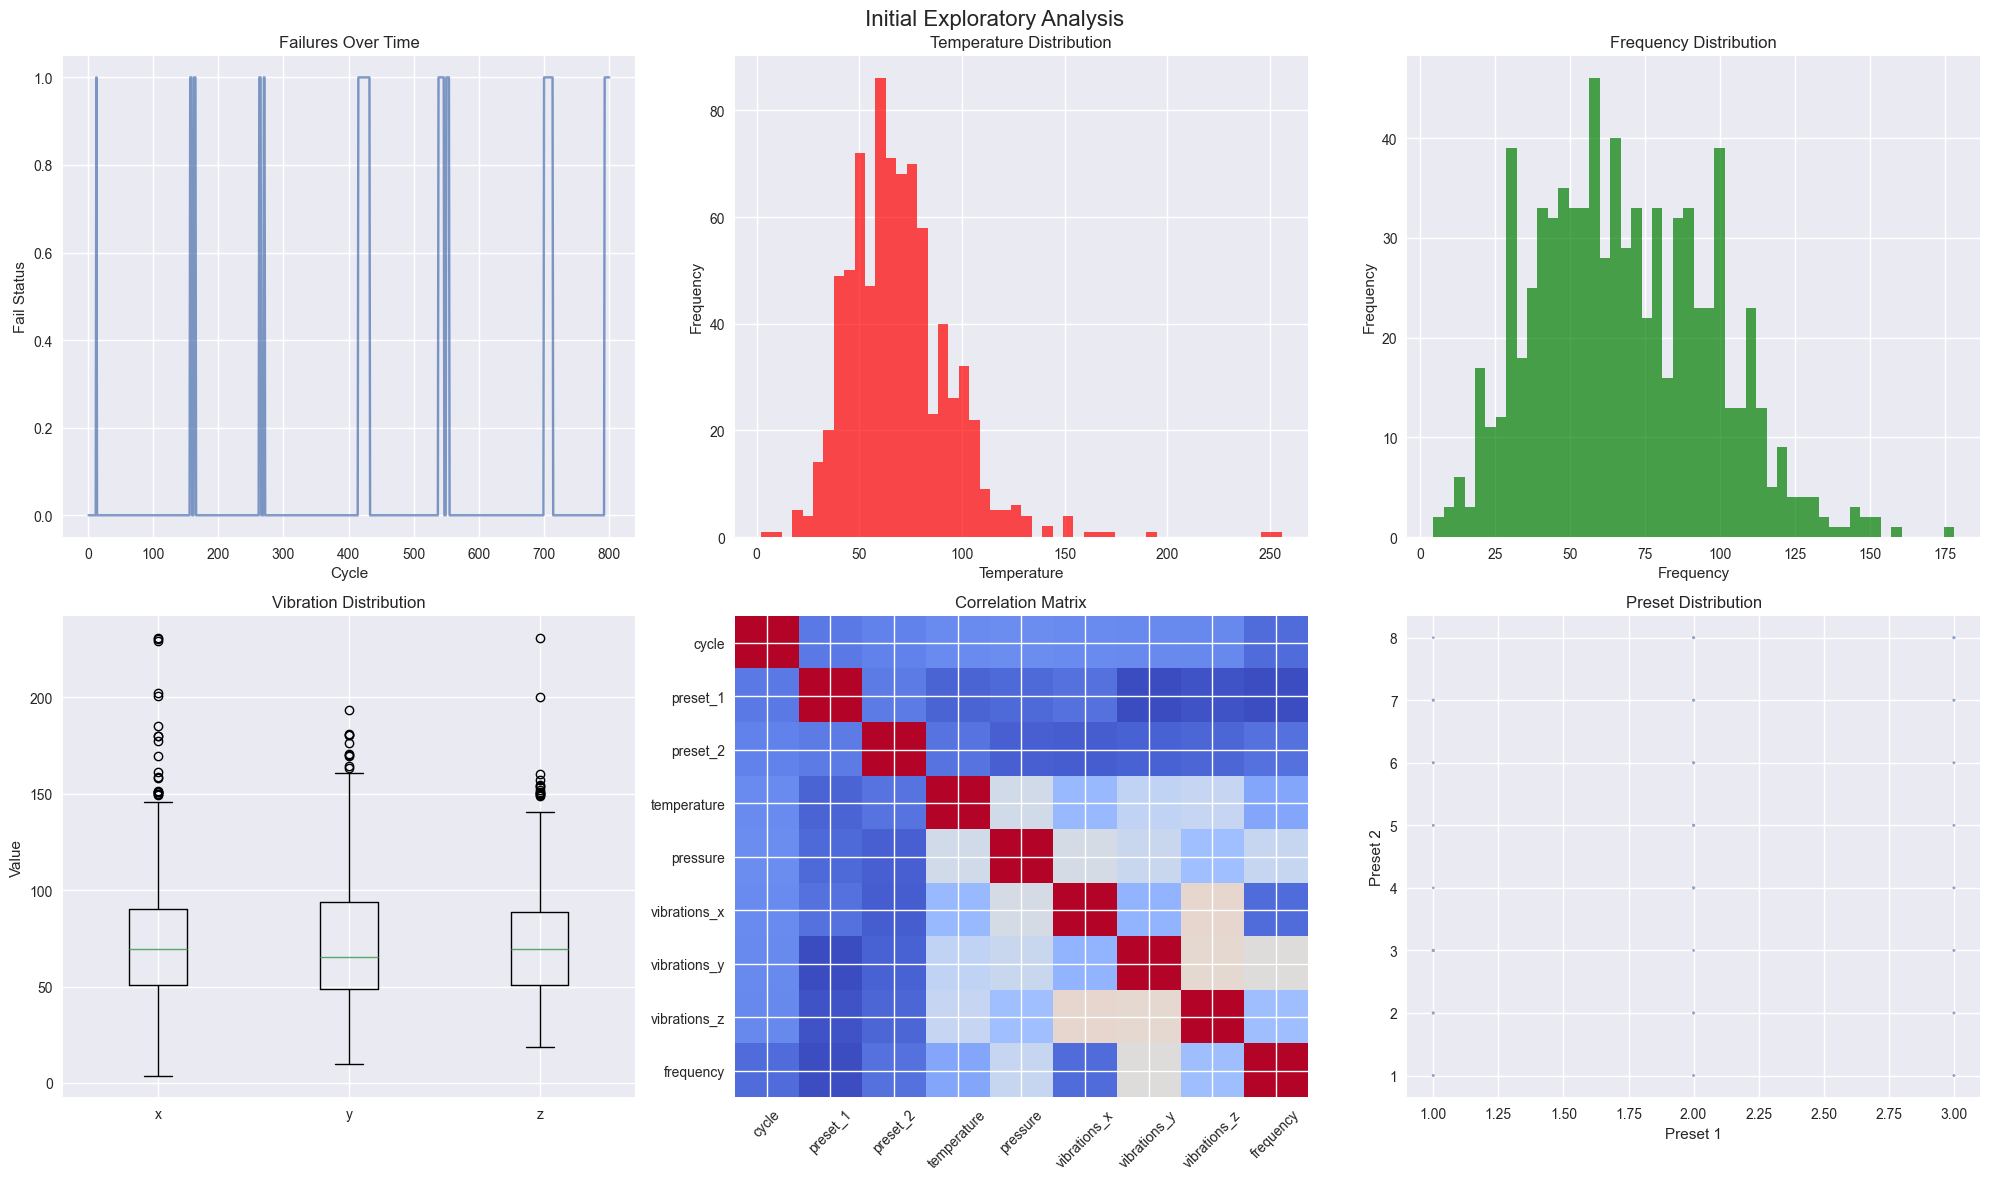

In [4]:
analyzer.initial_exploration()

# Task 1: Failure Analysis
Objective: Quantify equipment failure patterns

- Failure Rate: 8.25% (66 failures out of 800 records)
- Failure Events: 10 distinct failure episodes
- Average Duration: 6.6 cycles per failure event
- Key Finding: Equipment experiences clustered failures rather than random isolated incidents, suggesting underlying degradation patterns


TASK 1: FAILURE ANALYSIS

 BASIC STATS:
   - Total records: 800
   - Records with failure: 66
   - Failure rate: 8.25%

 FAILURE EVENTS:
   - Number of failure events: 10

  FAILURE DURATIONS:
   - Average duration: 6.6 cycles
   - Maximum duration: 18 cycles
   - Minimum duration: 1 cycles


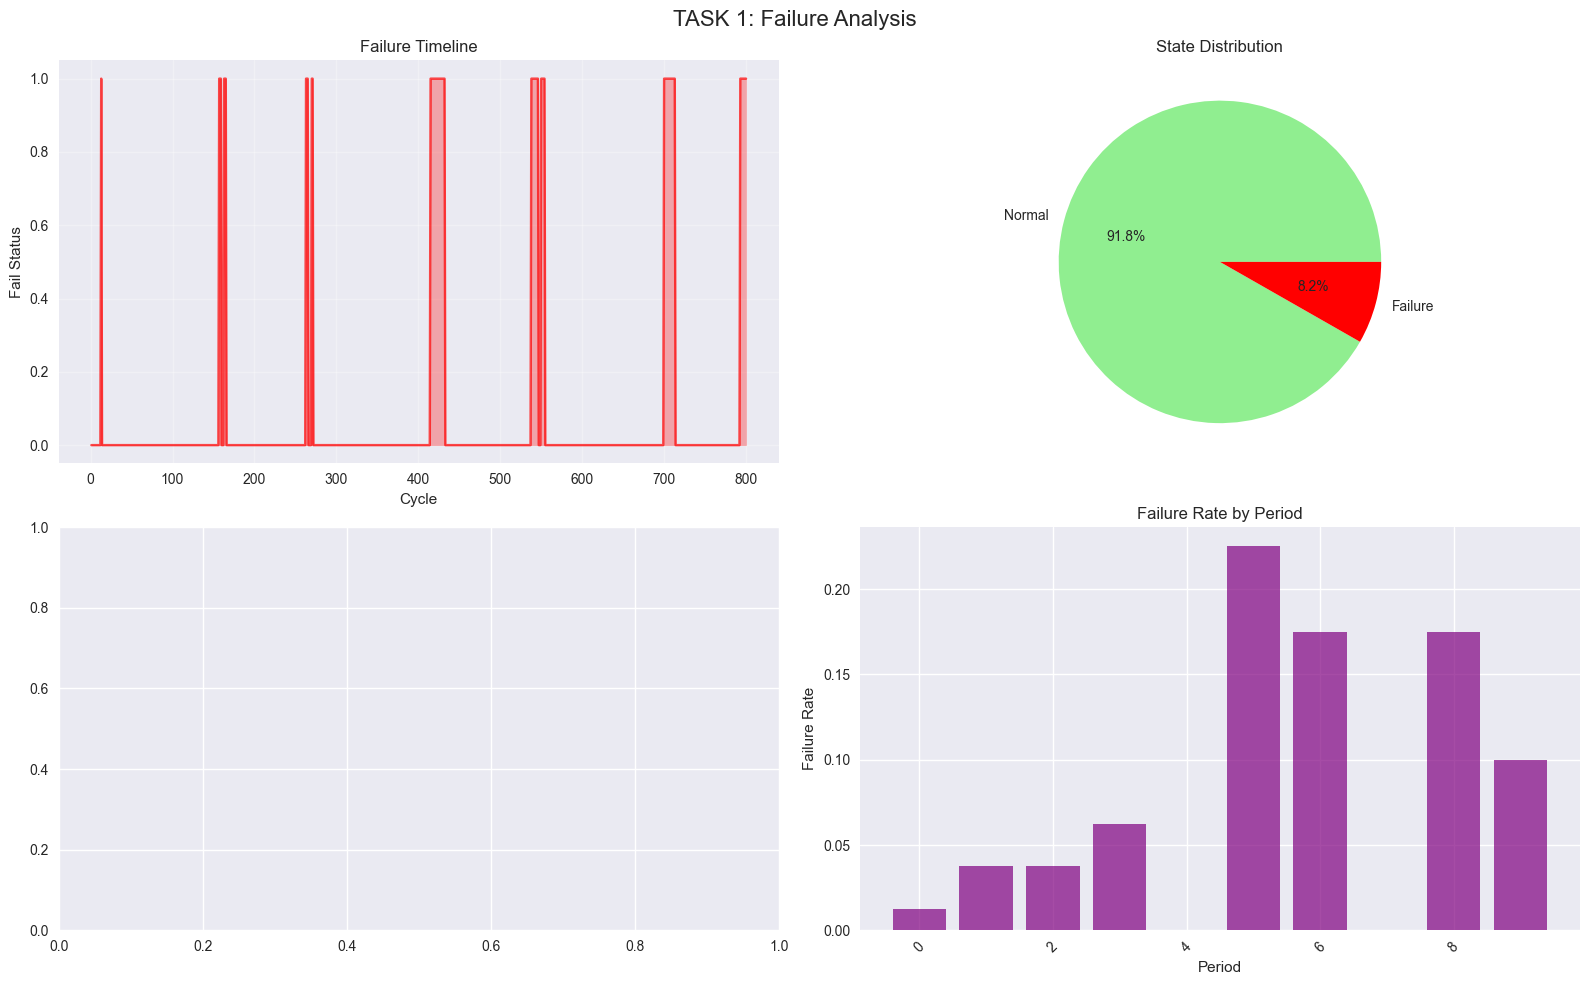

{'total_records': 800,
 'failure_records': np.int64(66),
 'failure_rate': np.float64(8.25),
 'failure_events': np.int64(10),
 'failure_durations': [1, 3, 3, 3, 2, 18, 9, 5, 14, 8]}

In [5]:
analyzer.task_1_count_failures()

# Task 2: Configuration Analysis
Objective: Identify failure-prone operational settings

- Highest Risk Combination: Preset 1=1, Preset 2=5 (16.13% failure rate)
- Most Problematic Individual Settings: Preset 1=1 (10.23%) and Preset 2=5 (12.0%)
- Configuration Stability: High variability with 528 and 705 changes respectively
- Key Finding: Certain operational configurations significantly increase failure probability, but overall correlation is weak (-0.047 and -0.017)


TASK 2: ANALYSIS BY CONFIGURATIONS (PRESETS)

 PRESET ANALYSIS:
   - Preset 1 - Unique values: 3
   - Preset 1 - Range: 1 to 3
   - Preset 2 - Unique values: 8
   - Preset 2 - Range: 1 to 8

 TOP 10 COMBINATIONS WITH HIGHEST FAILURE RATE:
 preset_1  preset_2  total_records  total_failures  failure_rate  cycles
        1         5             31               5        0.1613      31
        3         5             29               4        0.1379      29
        2         1             30               4        0.1333      30
        1         2             38               5        0.1316      38
        1         1             34               4        0.1176      34
        2         8             37               4        0.1081      37
        1         7             38               4        0.1053      38
        3         6             30               3        0.1000      30
        3         1             31               3        0.0968      31
        1         4           

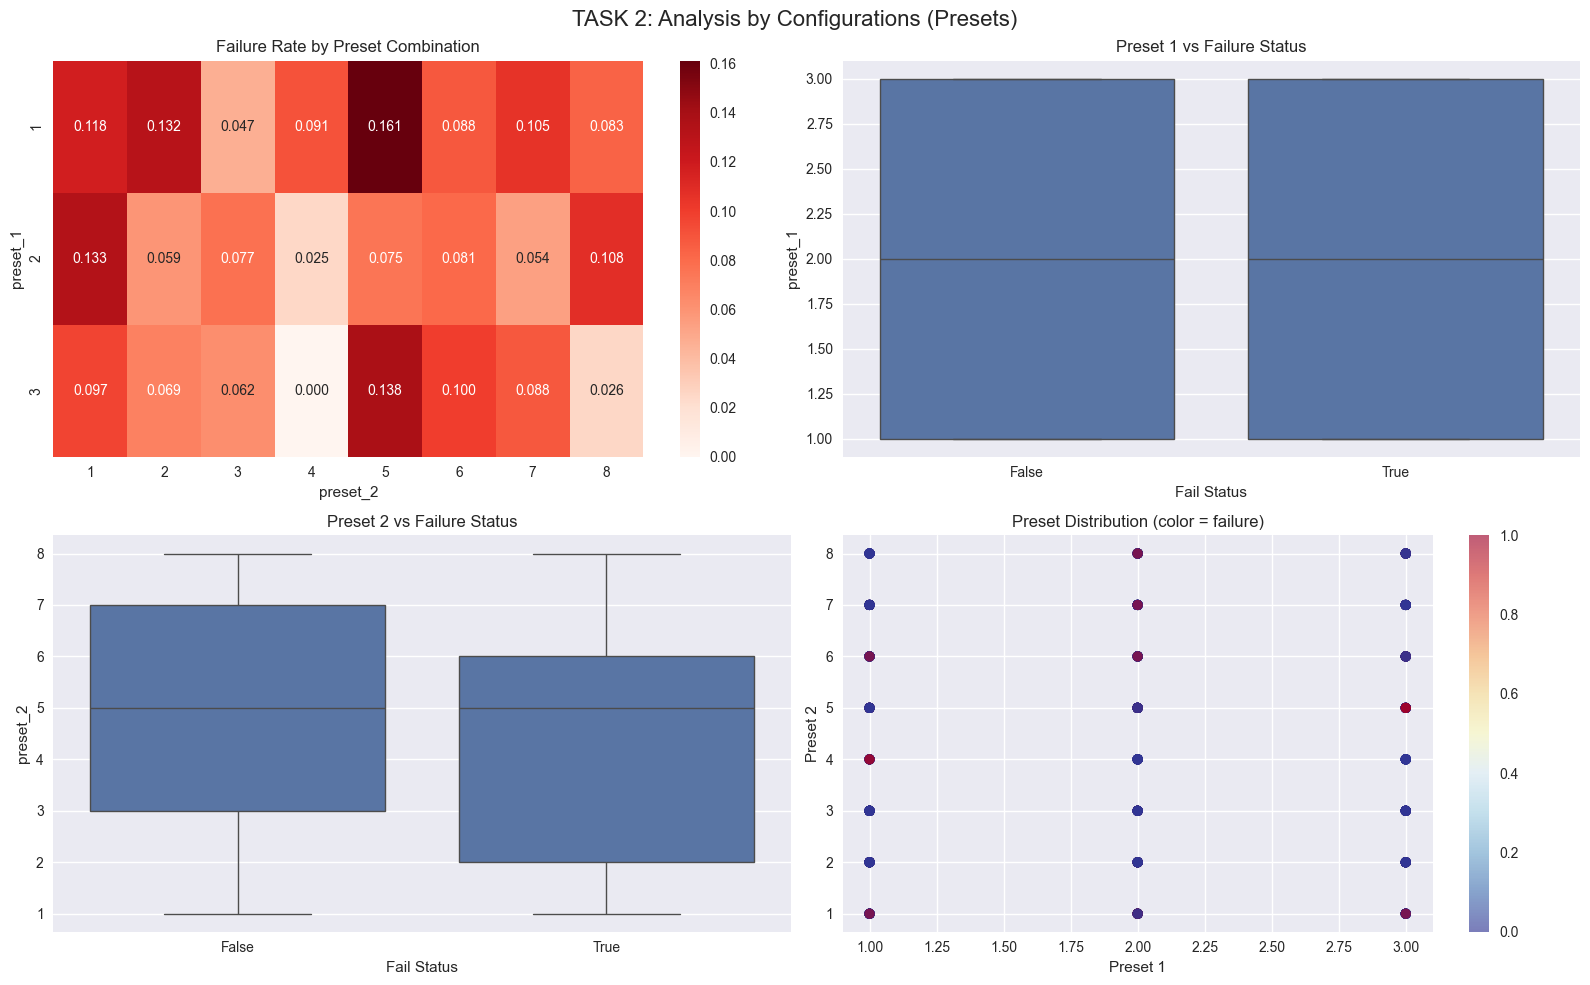

{'preset_combinations':     preset_1  preset_2  total_records  total_failures  failure_rate  cycles
 4          1         5             31               5        0.1613      31
 20         3         5             29               4        0.1379      29
 8          2         1             30               4        0.1333      30
 1          1         2             38               5        0.1316      38
 0          1         1             34               4        0.1176      34
 15         2         8             37               4        0.1081      37
 6          1         7             38               4        0.1053      38
 21         3         6             30               3        0.1000      30
 16         3         1             31               3        0.0968      31
 3          1         4             22               2        0.0909      22
 22         3         7             34               3        0.0882      34
 5          1         6             34               

In [6]:
analyzer.task_2_analyze_by_presets()

# Task 3: Root Cause Analysis
Objective: Determine physical parameters driving failures

- Primary Failure Indicator: Vibrations_Y (+79.3% during failures, p<0.001)
- Critical Threshold: Vibrations_Y > 121.50 indicates imminent failure
- Secondary Indicators: Temperature (+37.7%), Vibrations_Z (+54.1%), Frequency (+52.7%)
- Failure Classification: 48.5% mechanical (vibrations), 21.2% operational (frequency), 19.7% thermal
- Key Finding: Mechanical vibrations, particularly Y-axis, are the strongest predictors of equipment failure


TASK 3: ROOT CAUSE ANALYSIS

 STATISTICAL COMPARISON:
   - Normal records: 734
   - Failure records: 66

   TEMPERATURE:
      - Normal: 67.18 ± 24.82
      - Failure: 92.47 ± 21.68
      - Difference: 25.29 (37.7%)
      - Significance (p-value): 0.000000

   VIBRATIONS_X:
      - Normal: 71.49 ± 30.42
      - Failure: 100.17 ± 28.11
      - Difference: 28.67 (40.1%)
      - Significance (p-value): 0.000000

   VIBRATIONS_Y:
      - Normal: 68.32 ± 29.01
      - Failure: 122.48 ± 30.86
      - Difference: 54.16 (79.3%)
      - Significance (p-value): 0.000000

   VIBRATIONS_Z:
      - Normal: 68.80 ± 25.68
      - Failure: 106.00 ± 28.38
      - Difference: 37.21 (54.1%)
      - Significance (p-value): 0.000000

   FREQUENCY:
      - Normal: 65.38 ± 27.94
      - Failure: 99.81 ± 22.96
      - Difference: 34.43 (52.7%)
      - Significance (p-value): 0.000000

 CRITICAL THRESHOLDS:

   TEMPERATURE:
      - Normal (5th-95th percentile): 35.63 - 106.49
      - Failure (median): 90.93



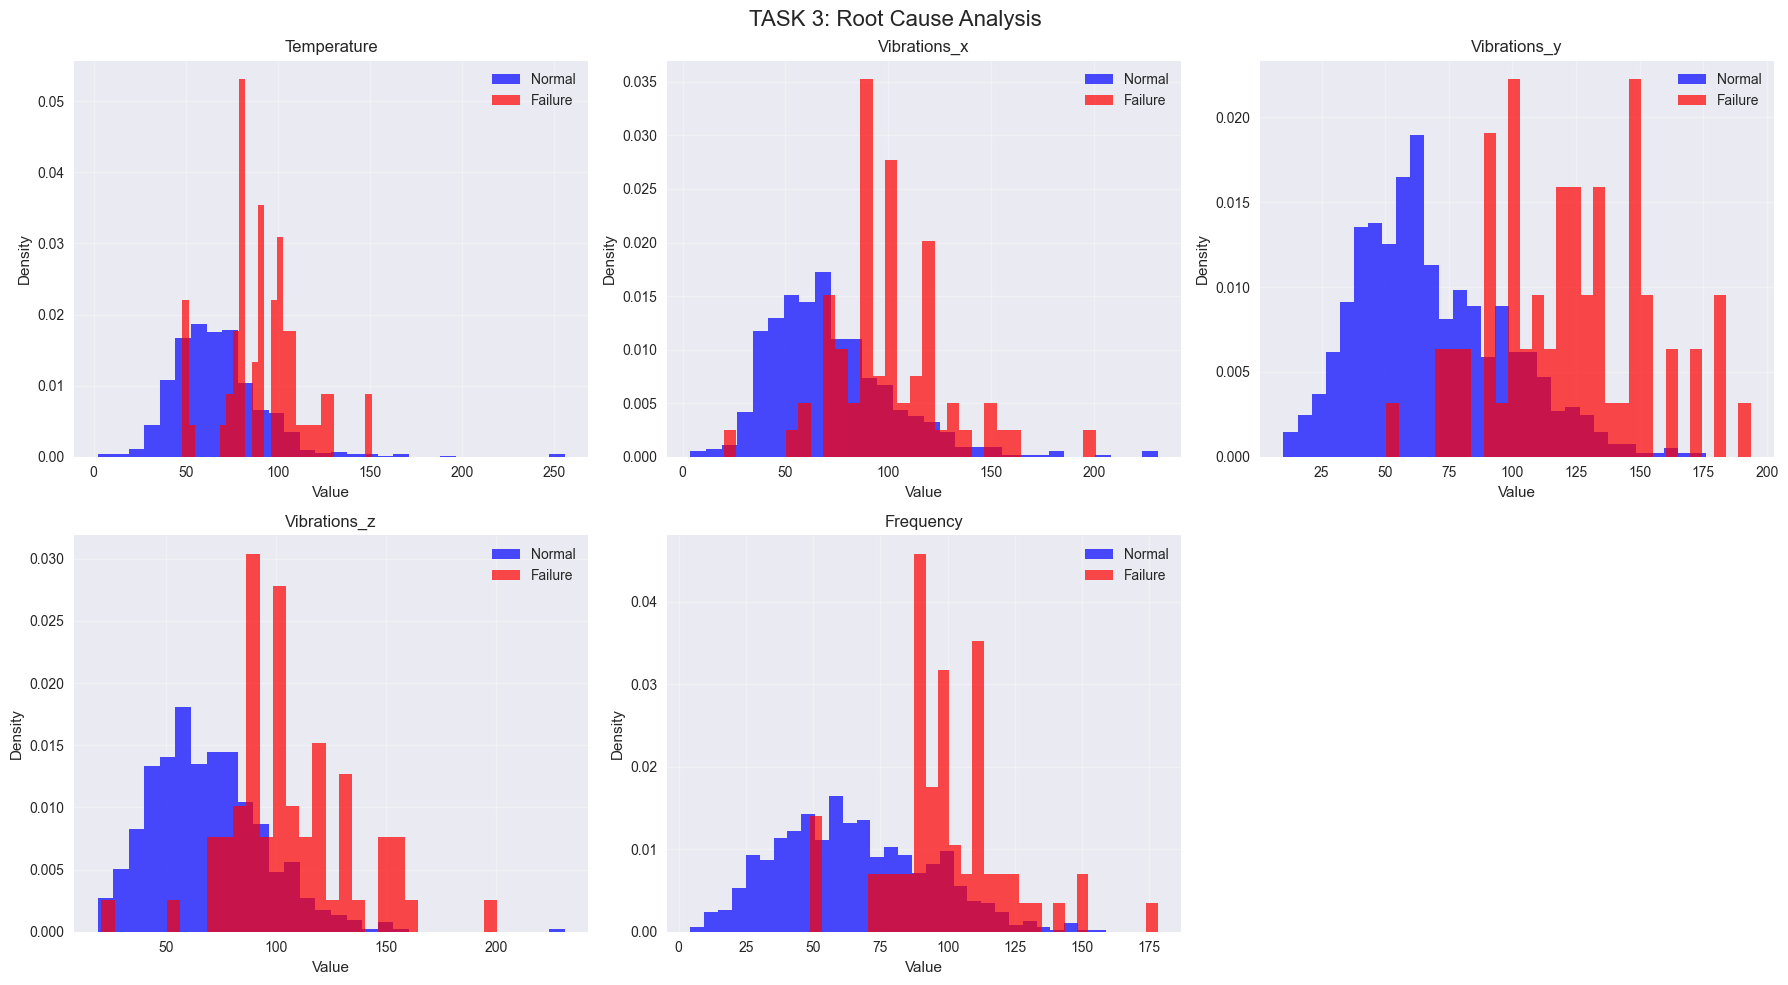

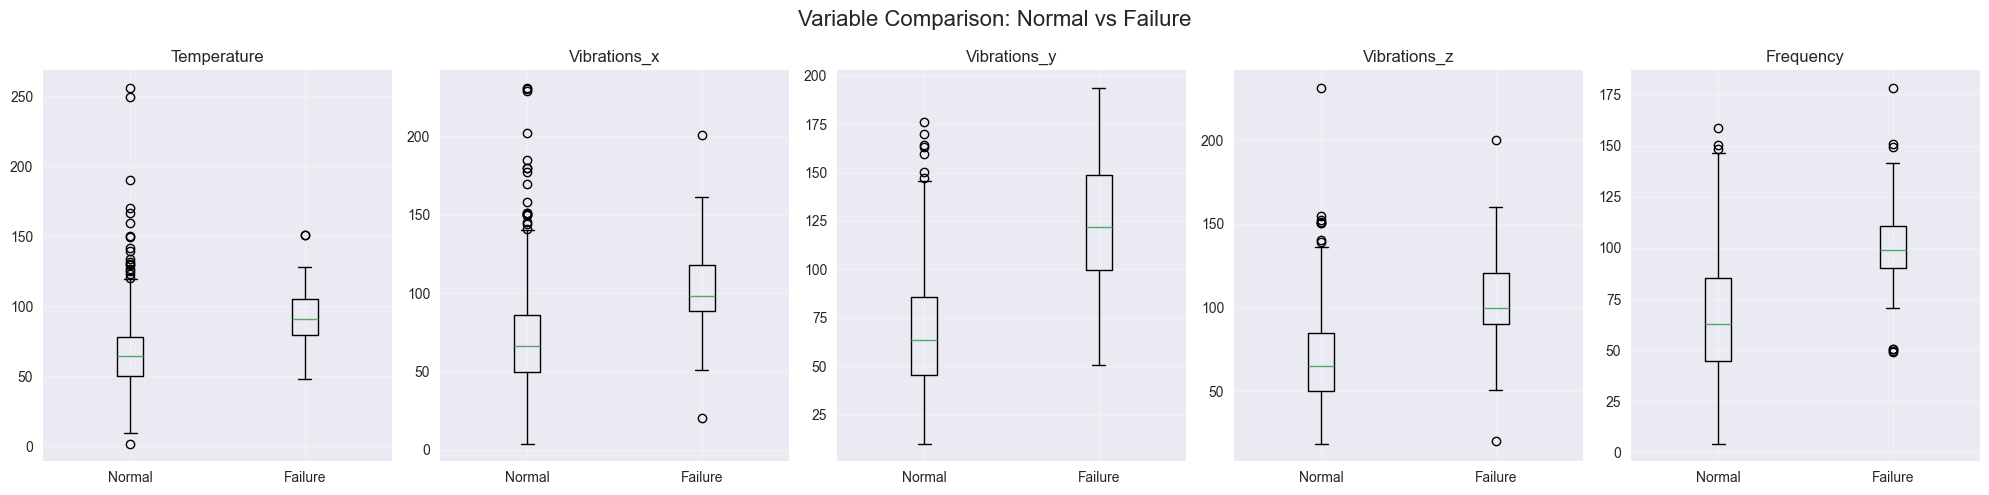

{'comparison_results': {'temperature': {'normal_mean': np.float64(67.17688368212775),
   'failure_mean': np.float64(92.46912471643634),
   'normal_std': np.float64(24.824880233834243),
   'failure_std': np.float64(21.68367039491586),
   'difference': np.float64(25.29224103430859),
   'percent_change': np.float64(37.65021484769697),
   't_statistic': np.float64(-8.005880800197495),
   'p_value': np.float64(4.183016832468228e-15)},
  'vibrations_x': {'normal_mean': np.float64(71.49480285867128),
   'failure_mean': np.float64(100.16718994404927),
   'normal_std': np.float64(30.415830780476274),
   'failure_std': np.float64(28.109402241398456),
   'difference': np.float64(28.67238708537799),
   'percent_change': np.float64(40.104155741301476),
   't_statistic': np.float64(-7.379643740084392),
   'p_value': np.float64(3.9891614351295825e-13)},
  'vibrations_y': {'normal_mean': np.float64(68.31845512604967),
   'failure_mean': np.float64(122.48115861191384),
   'normal_std': np.float64(29.01

In [7]:
analyzer.task_3_root_cause_analysis()

# Task 4: Predictive Modeling
Objective: Build failure prediction capability

- Best Model: Logistic Regression (AUC = 0.9783, F1 = 0.6667)
- Feature Engineering: 24 features including lag variables and rolling averages
- Model Performance: 92% accuracy with strong temporal cross-validation (0.9415 ± 0.0629)
- Data Split: 80/20 temporal split maintaining chronological integrity
- Key Finding: High predictive accuracy achieved, suitable for production deployment with proper monitoring


TASK 4: MODEL DEVELOPMENT

 FEATURE ENGINEERING:
   - Features created: 24
   - Records after cleaning: 796

 DATA SPLIT:
   - Train: 636 records (44 failures)
   - Test: 160 records (22 failures)

🔧 Training Logistic Regression...
   AUC Score: 0.9783
   F1 Score: 0.6667

🔧 Training Random Forest...
   AUC Score: 0.9567
   F1 Score: 0.6154

 TEMPORAL CROSS-VALIDATION:
   - Logistic Regression: 0.9415 ± 0.0629
   - Random Forest: 0.9692 ± 0.0163

BEST MODEL: Logistic Regression
   - AUC Score: 0.9783
   - F1 Score: 0.6667


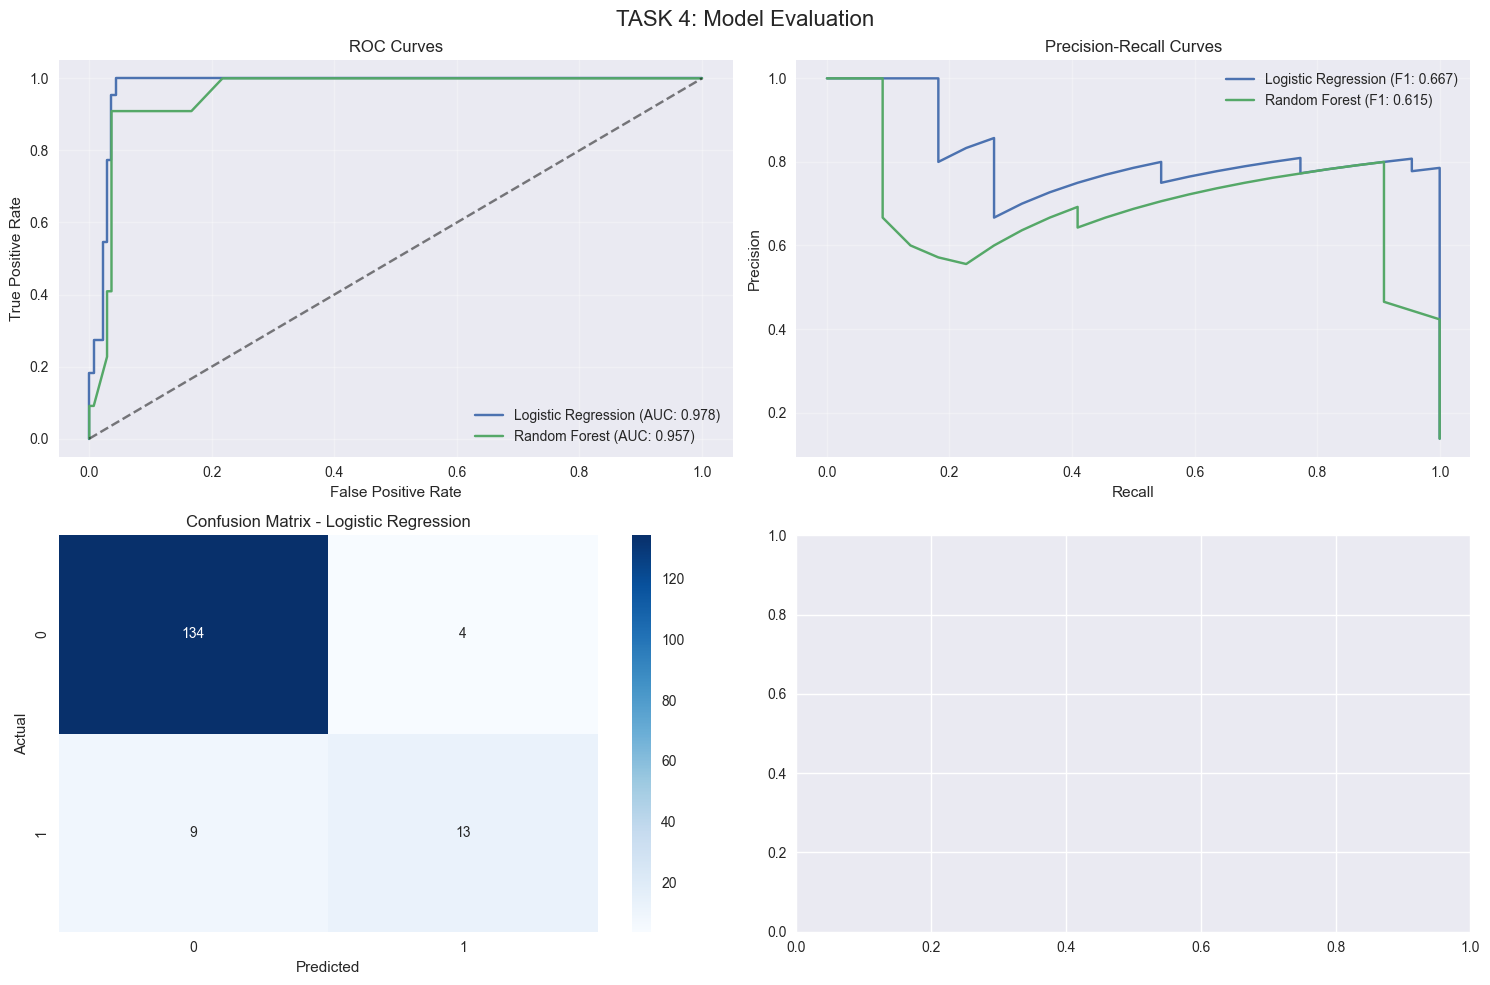

{'Logistic Regression': {'model': LogisticRegression(max_iter=1000, random_state=42),
  'predictions': array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False,
         False, False, False,  True,  True,  True,  True, False, False,
          True,  True,  True,  True, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False

In [8]:
analyzer.task_4_build_models()

# Task 5: Variable Importance Analysis
Objective: Rank factors by predictive power

- Top Predictors: Vibrations_Y rolling means (correlation >0.55), followed by Vibrations_Z rolling means (>0.50)
- Feature Type Impact: Rolling averages more predictive than instantaneous values
- Statistical Significance: All physical variables highly significant (p<0.001), presets not significant (p>0.05)
- Business Impact: Monitoring variables show strong correlation (>0.25), while controllable variables (presets) show weak correlation (<0.05)
- Key Finding: Temporal patterns in vibration data provide the strongest failure prediction capability


TASK 5: VARIABLE IMPORTANCE ANALYSIS

Analyzing importance for model: Logistic Regression

 FEATURE ENGINEERING:
   - Features created: 24
   - Records after cleaning: 796

 CORRELATION WITH FAILURES:
   vibrations_y_rolling_mean_3: 0.5567
   vibrations_y_rolling_mean_5: 0.5516
   vibrations_z_rolling_mean_5: 0.5235
   vibrations_z_rolling_mean_3: 0.5002
   vibrations_y: 0.4572
   temperature_rolling_mean_5: 0.4004
   temperature_rolling_mean_3: 0.3961
   vibrations_z: 0.3699
   vibrations_x_rolling_mean_5: 0.3690
   vibrations_x_rolling_mean_3: 0.3327

STATISTICAL SIGNIFICANCE (p-values):
   preset_1: p=0.188095 
   preset_2: p=0.638839 
   temperature: p=0.000000 ***
   vibrations_x: p=0.000000 ***
   vibrations_y: p=0.000000 ***
   vibrations_z: p=0.000000 ***
   frequency: p=0.000000 ***

 BUSINESS IMPACT:

  CONTROLLABLE VARIABLES (can be adjusted):
      - preset_1: Correlation = 0.0462
      - preset_2: Correlation = 0.0173

   MONITORING VARIABLES (failure indicators):
      -

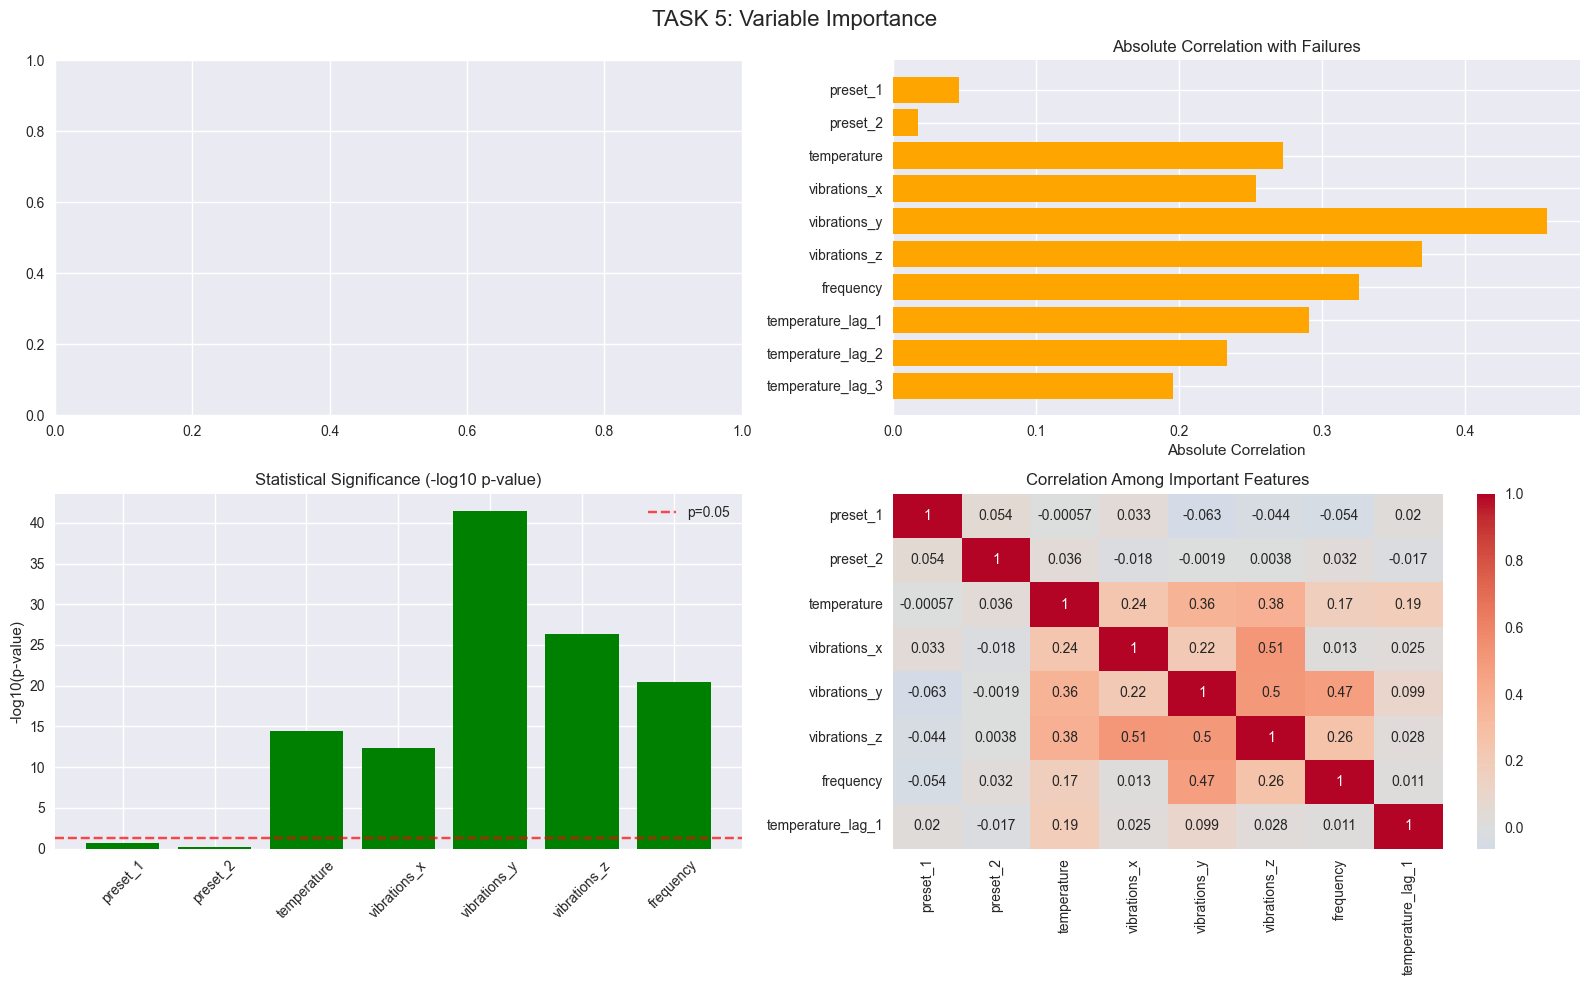

{'correlations': {'preset_1': np.float64(0.04615071046236592),
  'preset_2': np.float64(0.01734903681247512),
  'temperature': np.float64(0.27276862862735834),
  'vibrations_x': np.float64(0.2535700145054324),
  'vibrations_y': np.float64(0.457229781506753),
  'vibrations_z': np.float64(0.3699005706484757),
  'frequency': np.float64(0.32549534251100615),
  'temperature_lag_1': np.float64(0.29101130984362833),
  'temperature_lag_2': np.float64(0.23367410948389636),
  'temperature_lag_3': np.float64(0.19584974890549994),
  'frequency_lag_1': np.float64(0.29616979256820397),
  'frequency_lag_2': np.float64(0.26449773940800136),
  'frequency_lag_3': np.float64(0.2180900308063752),
  'temperature_rolling_mean_3': np.float64(0.3960832734345035),
  'temperature_rolling_mean_5': np.float64(0.40036166755119695),
  'vibrations_x_rolling_mean_3': np.float64(0.33266230894347293),
  'vibrations_x_rolling_mean_5': np.float64(0.36898516526639874),
  'vibrations_y_rolling_mean_3': np.float64(0.5566922

In [9]:
analyzer.task_5_variable_importance()